# Plot3D Python Tutorial
In this tutorial you will learn about the Plot3D NASA Standard and how to use NASA's Plot3D python library to read, write, find connectivity, split blocks, and find periodicity.

## About Plot3D
Plot3D is a standard for defining a simple structured grid. This standard was developed in the 1980's [User Manual](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiLm_2Q8JjzAhUCB50JHTfFCM4QFnoECAMQAQ&url=https%3A%2F%2Fwww.grc.nasa.gov%2Fwww%2Fwinddocs%2Ftowne%2Fplotc%2Fplotc_p3d.html&usg=AOvVaw0iKPGjnhjiQA9AFZcFhkEE) 

To understand the plot3D standard, we must first start with the definition of an array. The figure below shows a box with 6 faces and 8 verticies represented by black dots. Now if you were to discretize a geometry into many of these boxes all connected to each other. You would have many x,y,z points. To organize things we arrange all this points into an array of x's, y'z, z's and we label them as capital X, Y, Z. 

![Array](https://raw.githubusercontent.com/nasa/Plot3D_utilities/main/colab/images/array_definition.png)

So what does this mean? how is this helpful. It depends on how to arrange the array. If you have a single dimensional array of x like x<sub>1</sub>,x<sub>2</sub>,x<sub>3</sub>, ..., x<sub>n</sub>. This isn't particularly useful because it's hard to split it in to faces - just try it with the simple box above. So what we do instead is represent x as a 3-dimensional array instead of a single dimension. For example x[0,0,0] or x<sub>0,0,0</sub> = some value. 
The image below shows how we arrange the x values of each of the vertices. 


![Array](https://raw.githubusercontent.com/nasa/Plot3D_utilities/main/colab/images/array_definition2.png)

With this new arrangement of x into a 3-dimensional array, x[i,j,k]. We can easily extract a face. For example the front face is defined by x[0,0,0] x[1,0,0], x[0,1,0], x[1,1,0]. Do you notice anything interesting from this array? The third index "k" is 0. **To define a face you simply set either i, j, or k to be a constant value.** For outer faces you would use KMIN or KMAX. Depending on the programming language the indicies may start at 1 or 0. In python we start at 0 and end at n-1. [More info on Python Arrays](https://www.w3schools.com/python/python_arrays.asp)





# Environment Setup
This step is relatively short. Run the code below to install plot3d 

In [1]:
!pip install plot3d

# Reading and Writing a mesh file 
In simple words, a mesh is a collection of boxes arranged to form a shape. In this example we will explore reading a mesh in ASCII and saving it into a binary format. 




## Step 1: Load the functions from the library

In [2]:
from plot3d import read_plot3D, write_plot3D,Block
import pickle
import pprint

## Step 2: Download and read the mesh file
The code below reads the plot3D into a variable called blocks. "blocks" is a variable representing an array of plot3D blocks. You can think of a block as a 6 sided cube but inside the cube you have multiple smaller cubes. Cubes can be stretched and wrapped such that two ends are connected. This is called an o-mesh. We will plot this in a later step. 

In [3]:
!wget https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/PahtCascade-ASCII.xyz

--2021-12-08 17:48:16--  https://nasa-public-data.s3.amazonaws.com/plot3d_utilities/PahtCascade-ASCII.xyz
Resolving nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)... 52.217.73.148
Connecting to nasa-public-data.s3.amazonaws.com (nasa-public-data.s3.amazonaws.com)|52.217.73.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82072023 (78M) [application/x-www-form-urlencoded]
Saving to: ‘PahtCascade-ASCII.xyz’

PahtCascade-ASCII.x 100%[===================>]  78.27M  48.3MB/s    in 1.6s    

2021-12-08 17:48:18 (48.3 MB/s) - ‘PahtCascade-ASCII.xyz’ saved [82072023/82072023]



In [5]:
blocks = read_plot3D('PahtCascade-ASCII.xyz',binary=False)  # Reading plot3D
write_plot3D('PahtCascade-binary.xyz',blocks,binary=True)    # Writing plot3D to binary file

### Plotting the Mesh
The function below shows how we can plot an outline of the mesh 

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np 

def plot_block_outline(block:Block,ax:axes3d):
  IMAX,JMAX,KMAX = block.X.shape
  X = block.X 
  Y = block.Y
  Z = block.Z 

  for i in [0,IMAX-1]:    # Plots curves at constant I bounds 
    for j in [0,JMAX-1]:
      x = X[i,j,:]
      y = Y[i,j,:]
      z = Z[i,j,:]
      ax.plot3D(x,y,z)
  for j in [0,JMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[:,j,k]
        y = Y[:,j,k]
        z = Z[:,j,k]
        ax.plot3D(x,y,z)
  for i in [0,IMAX-1]:    # Plots curves at constant I bounds 
      for k in [0,KMAX-1]:
        x = X[i,:,k]
        y = Y[i,:,k]
        z = Z[i,:,k]
        ax.plot3D(x,y,z)


Try playing with this code to see if you can plot one block at a time. Also try changing the rotation 

we have 2 blocks


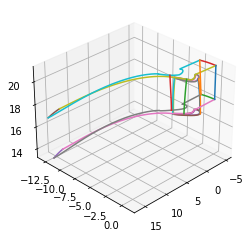

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
ax.view_init(30,45)

print("we have " + str(len(blocks)) + " blocks")

# Finding Connectivity
Connectivity tells the solver how information should transfer between Faces. For example, lets look at the example above. We have 2 blocks `blocks[0]` and `blocks[1]` These are connected via the pressure side of the blade. One of the features of the plot3d library is the ability to find connected faces between blocks as well as all the connected points. 

## Finding Connected Faces

The function `connectivity` takes in a parameter for blocks. The output is a list of face matches between blocks along with the outer faces which are faces that do not have a connection to another block. 

In [7]:
from plot3d import connectivity, connectivity_fast
face_matches, outer_faces_formatted = connectivity_fast(blocks)  # Running this code will take a while depending on how fast google colab is on a given day.
# or you can call `face_matches, outer_faces_formatted = connectivity_fast(blocks)` which works too but might be slower 
# Saving the results
with open('connectivity.pickle','wb') as f:
  pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_formatted},f)

Checking connections block 0 with 1: 100%|██████████| 1/1 [00:12<00:00, 12.42s/it]


### Representing connected faces 
`face_matches` contains matching face diagonals. The simpliest way to represent a face match is to use the following standard:

Block[0]-Face lower corner represented as [IMIN,JMIN,KMIN] and Face Upper corner represented as [IMAX,JMAX,KMAX] **is matched to** Block[1]-Face lower corner represented as [IMIN,JMIN,KMIN] and Face Upper corner represented as [IMAX,JMAX,KMAX]. 

![Face matching](https://github.com/nasa/Plot3D_utilities/blob/main/docs/_static/block_face_matching.png?raw=true)

`face_matches[0]['match']` is a dataframe of connected points. This is available to you in case you want to use it. 

You can see that below when we print out the dictionary 

In [ ]:
with open('connectivity.pickle','rb') as f:
  data = pickle.load(f)
  face_matches = data['face_matches']
  outer_faces = data['outer_faces']

face_matches
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(face_matches[0])

{   'block1': {   'IMAX': 256,
                  'IMIN': 128,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 32,
                  'KMIN': 32,
                  'block_index': 0},
    'block2': {   'IMAX': 168,
                  'IMIN': 40,
                  'JMAX': 100,
                  'JMIN': 0,
                  'KMAX': 0,
                  'KMIN': 0,
                  'block_index': 1},
    'match':         i1   j1  k1   i2   j2 k2
101    128    0  32   40    0  0
102    128    1  32   40    1  0
103    128    2  32   40    2  0
104    128    3  32   40    3  0
105    128    4  32   40    4  0
...    ...  ...  ..  ...  ... ..
13125  256   96  32  168   96  0
13126  256   97  32  168   97  0
13127  256   98  32  168   98  0
13128  256   99  32  168   99  0
13129  256  100  32  168  100  0

[13029 rows x 6 columns]}


## Plotting Connected Faces

In [ ]:
from matplotlib import cm
import numpy as np 

def select_multi_dimensional(T:np.ndarray,dim1:tuple,dim2:tuple, dim3:tuple):
    """Takes a block (T) and selects X,Y,Z from the block given a face's dimensions
        theres really no good way to do this in python 
    Args:
        T (np.ndarray): arbitrary array so say a full matrix containing X
        dim1 (tuple): 20,50 this selects X in the i direction from i=20 to 50
        dim2 (tuple): 40,60 this selects X in the j direction from j=40 to 60
        dim3 (tuple): 10,20 this selects X in the k direction from k=10 to 20

    Returns:
        np.ndarray: returns X or Y or Z given some range of I,J,K
    """
    if dim1[0] == dim1[1]:
        return T[ dim1[0], dim2[0]:dim2[1]+1, dim3[0]:dim3[1]+1 ]
    if dim2[0] == dim2[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0], dim3[0]:dim3[1]+1 ]
    if dim3[0] == dim3[1]:
        return T[ dim1[0]:dim1[1]+1, dim2[0]:dim2[1]+1, dim3[0] ]
    
    return T[dim1[0]:dim1[1], dim2[0]:dim2[1], dim3[0]:dim3[1]]

def plot_face(face_matches,blocks):
  for fm in face_matches:
    block_index1 = fm['block1']['block_index']
    I1 = [fm['block1']['IMIN'],fm['block1']['IMAX']] # [ IMIN IMAX ]
    J1 = [fm['block1']['JMIN'],fm['block1']['JMAX']] # [ JMIN JMAX ]
    K1 = [fm['block1']['KMIN'],fm['block1']['KMAX']] # [ KMIN KMAX ]

    block_index2 = fm['block2']['block_index']
    I2 = [fm['block2']['IMIN'],fm['block2']['IMAX']] # [ IMIN IMAX ]
    J2 = [fm['block2']['JMIN'],fm['block2']['JMAX']] # [ JMIN JMAX ]
    K2 = [fm['block2']['KMIN'],fm['block2']['KMAX']] # [ KMIN KMAX ]

    X1 = select_multi_dimensional(blocks[block_index1].X, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Y1 = select_multi_dimensional(blocks[block_index1].Y, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))
    Z1 = select_multi_dimensional(blocks[block_index1].Z, (I1[0],I1[1]), (J1[0],J1[1]), (K1[0],K1[1]))

    X2 = select_multi_dimensional(blocks[block_index2].X, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Y2 = select_multi_dimensional(blocks[block_index2].Y, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))
    Z2 = select_multi_dimensional(blocks[block_index2].Z, (I2[0],I2[1]), (J2[0],J2[1]), (K2[0],K2[1]))

    # return X1
    surf1 = ax.plot_surface(X1, Y1, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    surf2 = ax.plot_surface(X2, Y2, Z2, cmap=cm.coolwarm, linewidth=0, antialiased=True)


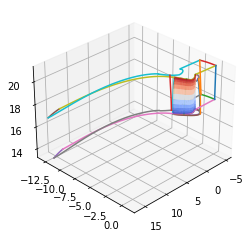

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
plot_face(face_matches,blocks)
ax.view_init(30,45)

## Periodic Faces
Perodicity is a subset of connectivity. **It relates to how Faces of blocks are connected when rotated by an angle.** You can think of an apple pie and slice it up into equal slices. Say you put in a filling into one of those slices. The filling will splurge over to the other slices. This is kind of what perodicity means. Data goes into one slice, it is transfered into other slices. You can also think of the game Portal.

In turbomachinery, simulating an entire turbine wheel requires many points, it is easier to break it into pie slices and apply periodicity/connectivity to the sides. 

In [ ]:
from plot3d import periodicity, Face

# This step may take a while. It is looking for periodicity for all surfaces that have constant "k"
periodic_surfaces, outer_faces_to_keep,periodic_faces,outer_faces = periodicity(blocks,outer_faces,face_matches,periodic_direction='k',rotation_axis='x',nblades=55)
with open('connectivity-periodic.pickle','wb') as f:
    [m.pop('match',None) for m in face_matches] # Remove the dataframe
    pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_to_keep, "periodic_surfaces":periodic_surfaces},f)


Checking connections block 0 with 0: 100%|██████████| 28/28 [00:32<00:00,  1.16s/it]


## Plotting Periodic Faces
This function outputs 4 things


1.   periodic_surfaces - this is list of all the surfaces/faces that match when rotated by an angle formatted as a dictionary.
2.   outer_faces_to_keep - These are the list of outer faces that are not periodic formatted as a dictionary.
3.   periodic_faces - is a list of `Face` objects that are connected to each other organized as a list of tuples: [Face1,  Face2] where Face 1 will contain the block number and the diagonals [IMIN,JMIN,KMIN,IMAX,JMAX,KMAX]. Example: blk: 1 [168,0,0,268,100,0].
4.   outer_faces - This is a list of outer faces save as a list of Faces

Try running the codes below to see how each of the variables is structured





In [ ]:
periodic_faces

[[blk: 1 [168,0,0,268,100,0], blk: 1 [168,0,52,268,100,52]],
 [blk: 1 [0,0,0,40,100,0], blk: 1 [0,0,52,40,100,52]],
 [blk: 0 [0,0,32,128,100,32], blk: 1 [40,0,52,168,100,52]]]

In [ ]:
outer_faces

[blk: 0 [0,0,0,256,0,32],
 blk: 0 [0,0,0,0,100,32],
 blk: 0 [0,0,0,256,100,0],
 blk: 1 [0,100,0,268,100,52],
 blk: 1 [0,0,0,268,0,52],
 blk: 1 [0,0,0,0,100,52],
 blk: 1 [268,0,0,268,100,52],
 blk: 0 [0,100,0,256,100,32],
 blk: 0 [256,0,0,256,100,32],
 blk: 1 [0,0,52,168,100,52],
 blk: 1 [40,0,52,268,100,52]]

Code below shows how to plot all the periodic surfaces. Matplotlib is not easy to use in colab environment. You can't really zoom or rotate. It is encouraged for you to use paraview to plot. There is a tutorial and examples in the docs https://nasa.github.io/Plot3D_utilities/docs/build/html/index.html 

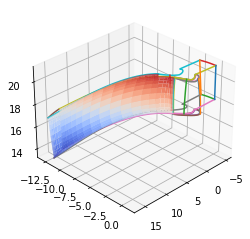

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
plot_face(periodic_surfaces[0:1],blocks)
ax.view_init(30,45)

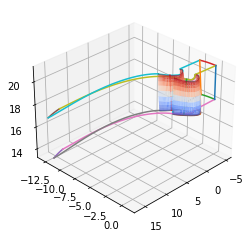

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot_block_outline(blocks[0],ax)
plot_block_outline(blocks[1],ax)
plot_face(periodic_surfaces[2:],blocks)
ax.view_init(30,45)

# Advance Topics

## Splitting the Blocks for Computational Efficiency
When solving a plot3D block it is often useful to break it into smaller blocks of a certain size. This will improve the speed by splitting the blocks and allowing each CPU core to solve a part of the mesh. BUT we also need to maintain something called multi-grid. 

### Multi-grid concept
Mulit-grid is a concept where you take a gird say 4x4 and you solve it as a 2x2 then interpolate the results on to the larger grid. The idea of solving a coarse grid and translating the solution onto a finer grid allows you to reach a converged solution much faster. So that's the benefits, what are the requirements? 

To achieve multi-grid you need to have something called GCD - greatest common divisor. What does this even mean? If your grid/block is 257 x 101 x 33 in size this means that the largest divisor is 4. This means we can reduce the mesh about 2 times

257x101x33 (Fine)    
129x51x17  (Coarse)  (Coarse)/2
65x26x9    (Coarser) (fine)/4

Try to example below to find GCD of a grid


In [ ]:
from math import gcd
grid_size = [257,101,33]
grid_size = [g-1 for g in grid_size]
temp = gcd(grid_size[0],gcd(grid_size[1],grid_size[2]))
print("Greatest common divisor is " + str(temp))

Greatest common divisor is 4


## Block split example

In [ ]:
from plot3d import split_blocks, Direction
blocks = read_plot3D('PahtCascade-ASCII.xyz',binary=False)  # Reading plot3D
blocks_split = split_blocks(blocks,300000, direction=Direction.i)
write_plot3D('PahtCascade-Split.xyz',blocks_split,binary=True)

### Connectivity using split blocks

In [ ]:
face_matches, outer_faces_formatted = connectivity(blocks_split)
with open('connectivity-block-split.pickle','wb') as f:
    pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_formatted},f)

Checking connections block 4 with 5: 100%|██████████| 15/15 [11:19<00:00, 45.28s/it]


In [ ]:
print("There are {0} face matches".format(len(face_matches)))
print("There are {0} outer faces".format(len(outer_faces_formatted)))

There are 7 face matches
There are 26 outer faces


In [ ]:
# Displaying face matches 
face_matches

In [ ]:
# Displaying outer_faces 
outer_faces_formatted

Plotting the Connectivity example

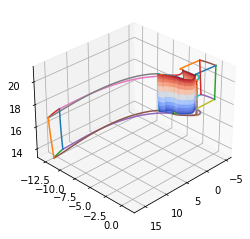

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
[plot_block_outline(block,ax) for block in blocks_split]
plot_face(face_matches,blocks_split)
ax.view_init(30,45)

### Periodicity using split blocks
Periodicity using split blocks is a bit interesting. There's lots of partial face matches etc. Again, it's really helpful to visualize using paraview than python, but I'll try to plot it for you anyways 

In [ ]:
with open('connectivity-block-split.pickle','rb') as f:
  data = pickle.load(f)
  face_matches = data['face_matches']
  outer_faces = data['outer_faces']

In [ ]:
blocks_split = read_plot3D('PahtCascade-Split.xyz', binary = True, big_endian=True)
periodic_surfaces, outer_faces_to_keep,periodic_faces,outer_faces = find_periodicity(blocks_split,outer_faces,periodic_direction='k',rotation_axis='x',nblades=55)
with open('connectivity-block-split_v02.pickle','wb') as f:
    [m.pop('match',None) for m in face_matches] # Remove the dataframe
    pickle.dump({"face_matches":face_matches, "outer_faces":outer_faces_to_keep, "periodic_surfaces":periodic_surfaces},f)

# Append periodic surfaces to face_matches
face_matches.extend(periodic_surfaces)

Checking connections block 1 with 1: 100%|██████████| 253/253 [02:26<00:00,  1.73it/s]


In [ ]:
# Displaying periodic surfaces
periodic_surfaces

In [ ]:
# Displaying face matches
face_matches